In [1]:
# If LightGBM isn’t already in your environment, run once:
# !pip install -q lightgbm==4.3.0


In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

plt.style.use("ggplot")


In [3]:
# folder that contains   AEP_merged.csv, COMED_merged.csv, …, etc.
MERGED_DIR = Path("merged_energy_temp")
files       = sorted(MERGED_DIR.glob("*_merged.csv"))
assert files, f"No *_merged.csv found in {MERGED_DIR.resolve()}"

MAX_LAG     = 3          # how many past-day lags of temperature to add
TEST_SPLIT  = 0.20       # 20 % of the tail is test
SEED        = 42

def add_time_features(df):
    """Add temperature lags + sin/cos day-of-year seasonality."""
    for lag in range(1, MAX_LAG + 1):
        df[f"Temp_lag{lag}"] = df["Estimated_Temp_C"].shift(lag)

    doy = df.index.dayofyear
    df["sin_DOY"] = np.sin(2 * np.pi * doy / 365.25)
    df["cos_DOY"] = np.cos(2 * np.pi * doy / 365.25)
    return df


In [4]:
region_rmse  = {}
models       = {}

for csv_path in files:
    region = csv_path.stem.split("_")[0]
    df     = pd.read_csv(csv_path, index_col=0, parse_dates=True)

    mw_col = df.columns[0]                    # first column = MW
    df     = df.rename(columns={mw_col: "Energy"})
    df     = add_time_features(df).dropna().sort_index()

    y = df["Energy"].values
    feature_cols = ["Estimated_Temp_C",
                    *[f"Temp_lag{i}" for i in range(1, MAX_LAG + 1)],
                    "sin_DOY", "cos_DOY"]
    X = df[feature_cols].values

    split = int(len(df) * (1 - TEST_SPLIT))
    X_tr, X_te, y_tr, y_te = X[:split], X[split:], y[:split], y[split:]

    model = LGBMRegressor(
        n_estimators     = 400,
        learning_rate    = 0.05,
        # Either keep one constraint …
        max_depth        = -1,     # -1 ⟹ no depth limit
        # … OR use both together:
        # max_depth        = 6,
        # num_leaves       = 64,    # make sure 2^max_depth ≤ num_leaves
        subsample        = 0.8,
        colsample_bytree = 0.8,
        objective        = "regression",
        random_state     = SEED,
        n_jobs           = -1,
    )
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    rmse   = mean_squared_error(y_te, y_pred, squared=False)

    region_rmse[region] = rmse
    models[region]      = model


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 4041, number of used features: 6
[LightGBM] [Info] Start training from score 15696.782313
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1514
[LightGBM] [Info] Number of data points in the train set: 2215, number of used features: 6
[LightGBM] [Info] Start training from score 11477.476971
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 4041, number of used features: 6
[LightGBM] [Info] Start t

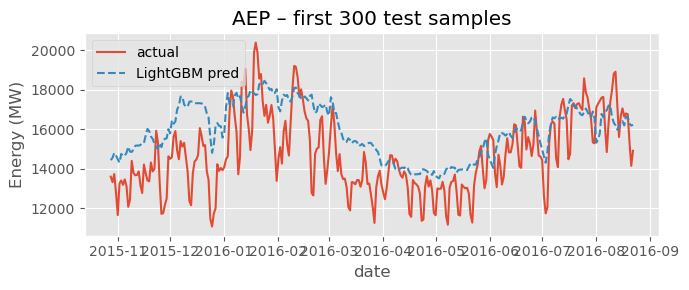

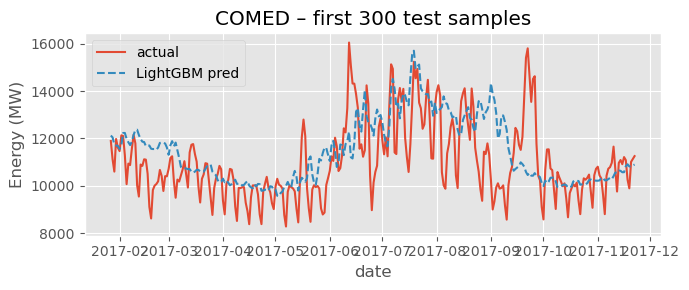

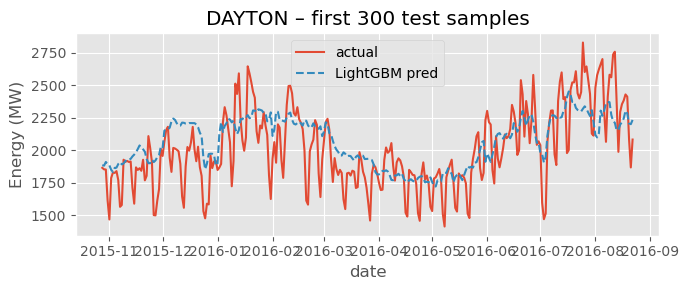

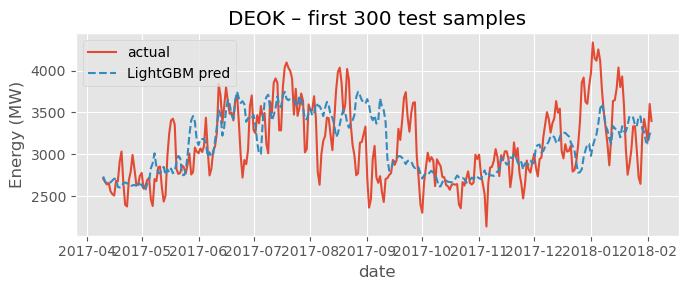

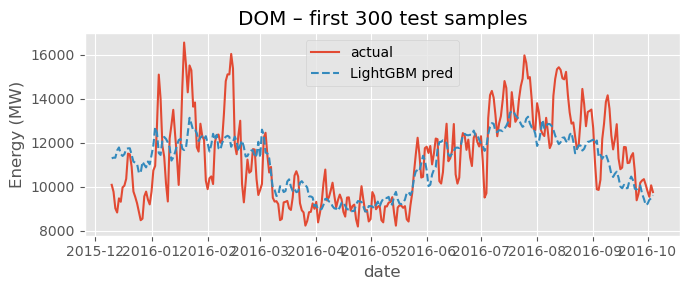

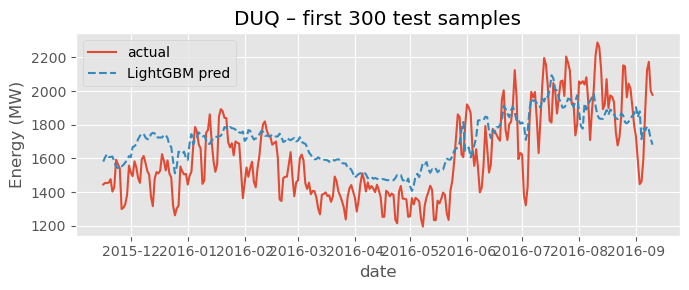

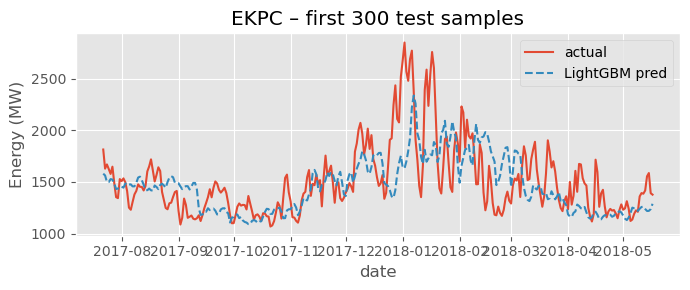

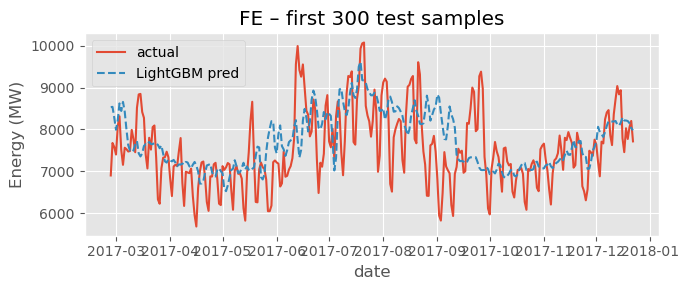

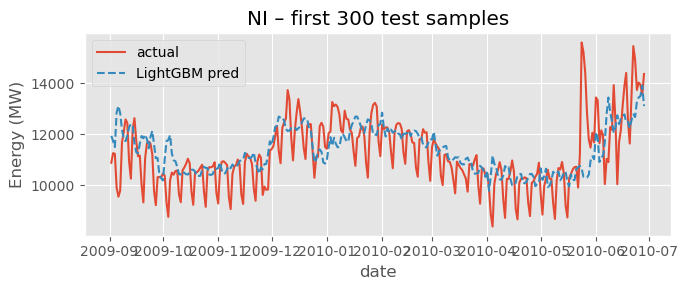

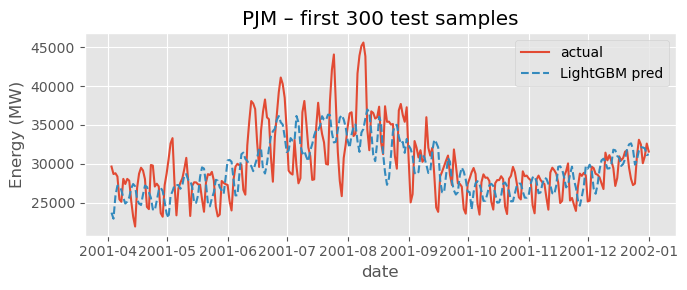

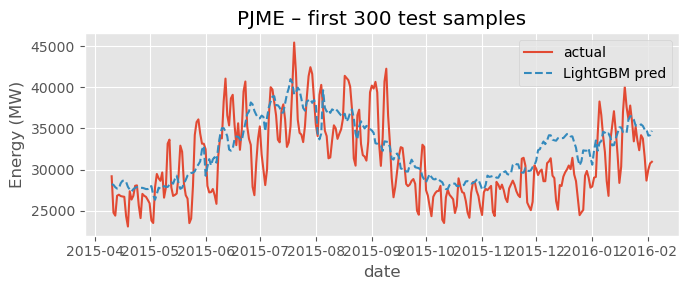

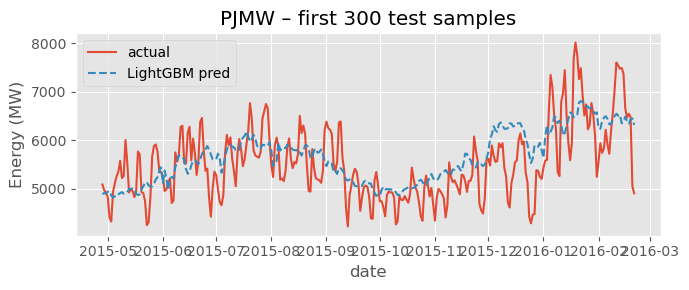

In [5]:
for region, model in models.items():
    df = pd.read_csv(MERGED_DIR / f"{region}_merged.csv",
                     index_col=0, parse_dates=True)

    # --- ensure first column is called "Energy" ---------------------------
    mw_col = df.columns[0]
    df = df.rename(columns={mw_col: "Energy"})

    df = add_time_features(df).dropna().sort_index()

    split = int(len(df) * (1 - TEST_SPLIT))
    X_te  = df.iloc[split:][feature_cols].values
    y_te  = df.iloc[split:]["Energy"].values
    y_pred = model.predict(X_te)

    plt.figure(figsize=(7,3))
    idx = df.index[split:][:300]
    plt.plot(idx, y_te[:300], label="actual")
    plt.plot(idx, y_pred[:300], "--", label="LightGBM pred")
    plt.title(f"{region} – first 300 test samples")
    plt.ylabel("Energy (MW)"); plt.xlabel("date")
    plt.legend(); plt.tight_layout(); plt.show()


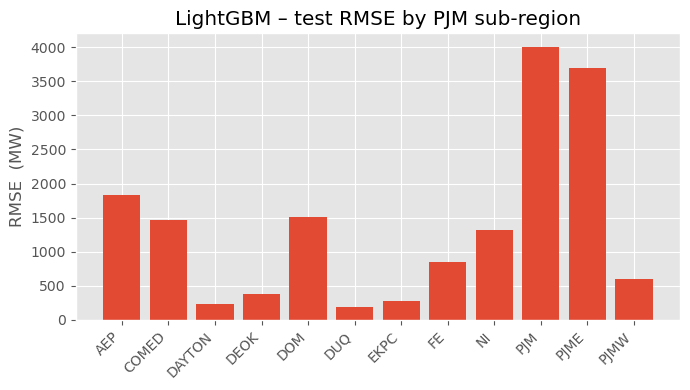

In [6]:
plt.figure(figsize=(7,4))
regions, rmses = zip(*sorted(region_rmse.items(), key=lambda x: x[0]))
plt.bar(regions, rmses)
plt.ylabel("RMSE  (MW)")
plt.title("LightGBM – test RMSE by PJM sub-region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
pd.Series(region_rmse, name="RMSE").to_csv("lightgbm_rmse_by_region.csv")
print("Saved: lightgbm_rmse_by_region.csv")


Saved: lightgbm_rmse_by_region.csv


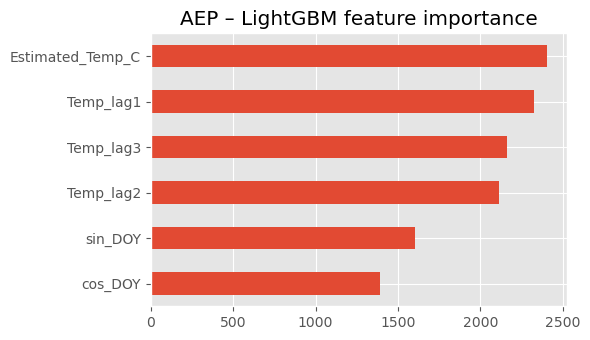

In [8]:
region = "AEP"                          # pick any trained region
model  = models[region]

importances = model.feature_importances_
pd.Series(importances, index=feature_cols).sort_values().plot.barh(figsize=(6,3.5))
plt.title(f"{region} – LightGBM feature importance")
plt.tight_layout(); plt.show()
